In [25]:
# Core Python & OS
import os
import shutil
import random
from pathlib import Path

# Data and Image Handling
import numpy as np
import cv2
from PIL import Image

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning Utilities
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, confusion_matrix

# TensorFlow / Keras
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint

# Face Detection
from mtcnn import MTCNN


In [2]:
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available: 1


2025-04-18 23:58:55.373995: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-04-18 23:58:55.912844: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-04-18 23:58:55.913025: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


In [6]:
IMG_SIZE = (299, 299)  # Xception's default input
BATCH_SIZE = 32
DATA_DIR = Path("dataset_xception")

In [7]:
DATA_DIR = Path("dataset_xception")
users = [d for d in DATA_DIR.iterdir() if d.is_dir()]

for user in users:
    fake_dir = user / "fake"
    if not fake_dir.exists():
        continue

    # Only top-level images (not already moved)
    fake_images = sorted([f for f in fake_dir.glob("*.jpg") if f.is_file()])
    total = len(fake_images)

    if total < 3:
        print(f"⚠️ Skipping {user.name} — not enough fake images.")
        continue

    # Even split into 3 chunks
    split_size = total // 3
    splits = [fake_images[:split_size],
              fake_images[split_size:2*split_size],
              fake_images[2*split_size:]]

    # Create id1, id2, id3 and move
    for i, split in enumerate(splits, 1):
        subfolder = fake_dir / f"id{i}"
        subfolder.mkdir(parents=True, exist_ok=True)
        for img in split:
            destination = subfolder / img.name
            shutil.move(str(img), destination)

    print(f"✅ Split {user.name} → id1: {len(splits[0])}, id2: {len(splits[1])}, id3: {len(splits[2])}")

# ✅ Verification: Loop through each user and print subfolder info
print("\n📦 Verifying structure of 'fake' folders...\n")
for user in users:
    fake_dir = user / "fake"
    if not fake_dir.exists():
        continue
    print(f"📁 {user.name}/fake:")
    for i in range(1, 4):
        subfolder = fake_dir / f"id{i}"
        count = len(list(subfolder.glob("*.jpg"))) if subfolder.exists() else 0
        print(f"   ├── id{i}: {count} images")


⚠️ Skipping Camil — not enough fake images.
⚠️ Skipping Jad — not enough fake images.
⚠️ Skipping Joe — not enough fake images.
⚠️ Skipping Joevany — not enough fake images.
⚠️ Skipping Joey — not enough fake images.
⚠️ Skipping Malih — not enough fake images.
⚠️ Skipping Maroun — not enough fake images.
⚠️ Skipping Ryan — not enough fake images.
⚠️ Skipping Thalia — not enough fake images.

📦 Verifying structure of 'fake' folders...

📁 Camil/fake:
   ├── id1: 57 images
   ├── id2: 57 images
   ├── id3: 58 images
📁 Jad/fake:
   ├── id1: 54 images
   ├── id2: 54 images
   ├── id3: 54 images
📁 Joe/fake:
   ├── id1: 49 images
   ├── id2: 49 images
   ├── id3: 49 images
📁 Joevany/fake:
   ├── id1: 42 images
   ├── id2: 42 images
   ├── id3: 42 images
📁 Joey/fake:
   ├── id1: 41 images
   ├── id2: 41 images
   ├── id3: 41 images
📁 Malih/fake:
   ├── id1: 55 images
   ├── id2: 55 images
   ├── id3: 55 images
📁 Maroun/fake:
   ├── id1: 55 images
   ├── id2: 55 images
   ├── id3: 55 images
📁 R

In [10]:
def load_split_paths(faces_root="dataset_xception"):
    train_paths, val_paths = [], []
    train_labels, val_labels = [], []

    users = [u for u in Path(faces_root).iterdir() if u.is_dir()]

    for user in users:
        real_dir = user / "real"
        fake_id1 = user / "fake" / "id1"
        fake_id2 = user / "fake" / "id2"
        fake_id3 = user / "fake" / "id3"

        # Real images (split 80% train / 20% val)
        real_images = sorted(real_dir.glob("*.jpg"))
        random.shuffle(real_images)
        split_idx = int(0.8 * len(real_images))
        train_paths += real_images[:split_idx]
        val_paths += real_images[split_idx:]
        train_labels += [0] * split_idx
        val_labels += [0] * (len(real_images) - split_idx)

        # Fake images
        fake_train = sorted(fake_id1.glob("*.jpg")) + sorted(fake_id2.glob("*.jpg"))
        fake_val = sorted(fake_id3.glob("*.jpg"))
        train_paths += fake_train
        val_paths += fake_val
        train_labels += [1] * len(fake_train)
        val_labels += [1] * len(fake_val)

    return train_paths, val_paths, train_labels, val_labels

# ✅ Call the function to get the paths and labels
train_paths, val_paths, train_labels, val_labels = load_split_paths("dataset_xception")

# Count real vs fake in training
real_train = sum(1 for p in train_paths if "/real/" in str(p) or "\\real\\" in str(p))
fake_train = sum(1 for p in train_paths if "/fake/" in str(p) or "\\fake\\" in str(p))

# Count real vs fake in validation
real_val = sum(1 for p in val_paths if "/real/" in str(p) or "\\real\\" in str(p))
fake_val = sum(1 for p in val_paths if "/fake/" in str(p) or "\\fake\\" in str(p))

print(f"Train total: {len(train_paths)} | Real: {real_train} | Fake: {fake_train}")
print(f"Val total: {len(val_paths)} | Real: {real_val} | Fake: {fake_val}")


Train total: 1302 | Real: 394 | Fake: 908
Val total: 557 | Real: 102 | Fake: 455


In [11]:
def show_samples(paths, labels, num_samples=8, title="Sample Images"):
    plt.figure(figsize=(16, 4))
    indices = random.sample(range(len(paths)), num_samples)

    for i, idx in enumerate(indices):
        img_path = str(paths[idx])
        label = labels[idx]
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        plt.subplot(1, num_samples, i + 1)
        plt.imshow(img)

        label_str = "Real" if label == 0 else "Fake"
        plt.title(f"{label_str}")
        plt.axis("off")

    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()


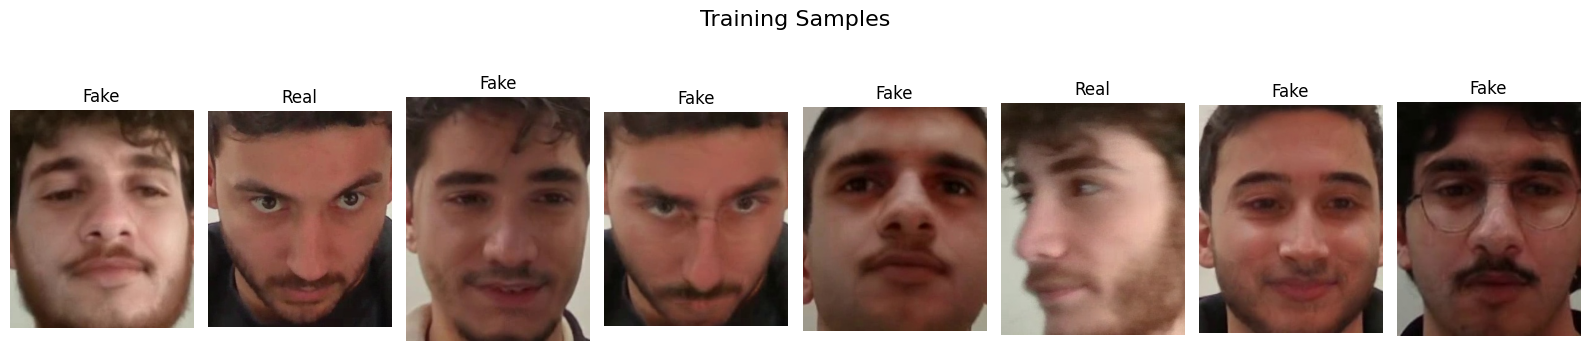

In [12]:
# Show samples from training set
show_samples(train_paths, train_labels, num_samples=8, title="Training Samples")

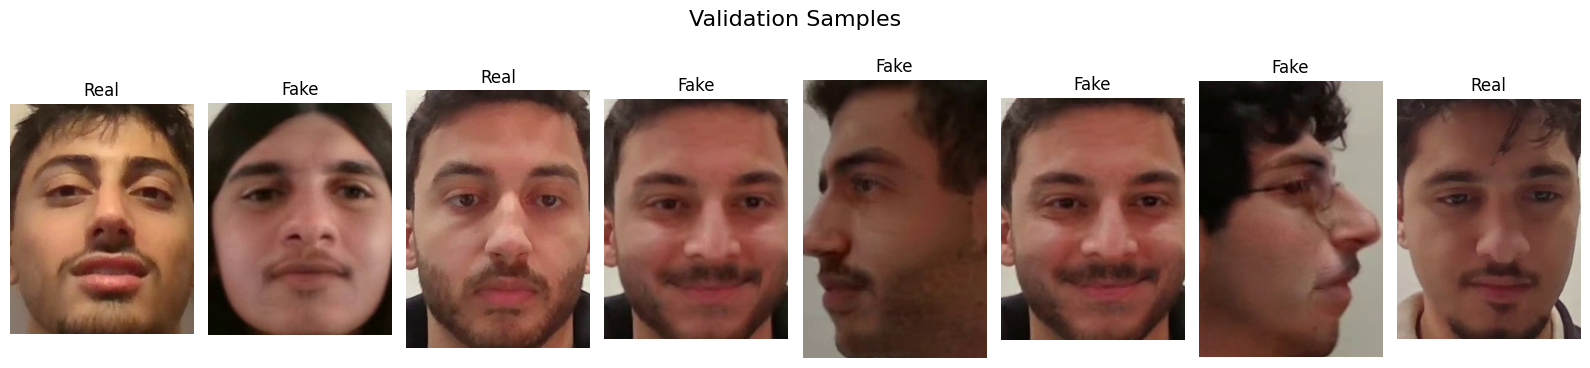

In [13]:
# Show samples from validation set
show_samples(val_paths, val_labels, num_samples=8, title="Validation Samples")

In [14]:
def augment_fn(img):
    img = tf.image.random_flip_left_right(img)
    img = tf.image.random_brightness(img, max_delta=0.1)
    img = tf.image.random_contrast(img, lower=0.9, upper=1.1)
    img = tf.image.random_saturation(img, lower=0.9, upper=1.1)
    img = tf.image.random_hue(img, max_delta=0.02)
    img = tf.image.random_crop(img, size=[int(IMG_SIZE[0] * 0.95), int(IMG_SIZE[1] * 0.95), 3])
    img = tf.image.resize(img, IMG_SIZE)  # Resize back
    return img

def preprocess_fn(img, training=False):
    img = tf.image.resize(img, IMG_SIZE)
    if training:
        img = augment_fn(img)
    img = tf.keras.applications.xception.preprocess_input(img)
    return img

def load_and_preprocess(path, label, training=False):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    return preprocess_fn(img, training), tf.cast(label, tf.int32)


# Fix the path types
train_paths = [str(p) for p in train_paths]
val_paths = [str(p) for p in val_paths]

AUTOTUNE = tf.data.AUTOTUNE

train_gen = tf.data.Dataset.from_tensor_slices((train_paths, train_labels))\
    .map(lambda x, y: load_and_preprocess(x, y, training=True), num_parallel_calls=AUTOTUNE)\
    .shuffle(1000).batch(BATCH_SIZE).prefetch(AUTOTUNE)

val_gen = tf.data.Dataset.from_tensor_slices((val_paths, val_labels))\
    .map(lambda x, y: load_and_preprocess(x, y, training=False), num_parallel_calls=AUTOTUNE)\
    .batch(BATCH_SIZE).prefetch(AUTOTUNE)



2025-04-19 01:18:17.180444: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-04-19 01:18:17.395994: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-04-19 01:18:17.396100: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-04-19 01:18:17.406722: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-04-19 01:18:17.406855: I external/local_xla/xla/stream_executor

In [15]:
def show_preprocessed_batch(dataset, title="Batch Samples"):
    for images, labels in dataset.take(1):  # Take one batch
        plt.figure(figsize=(16, 4))
        for i in range(min(8, images.shape[0])):
            ax = plt.subplot(1, 8, i + 1)
            img = (images[i].numpy() + 1) * 127.5  # de-normalize for Xception [-1, 1] → [0, 255]
            plt.imshow(img.astype("uint8"))
            label = "Fake" if labels[i].numpy() == 1 else "Real"
            plt.title(label)
            plt.axis("off")
        plt.suptitle(title)
        plt.show()

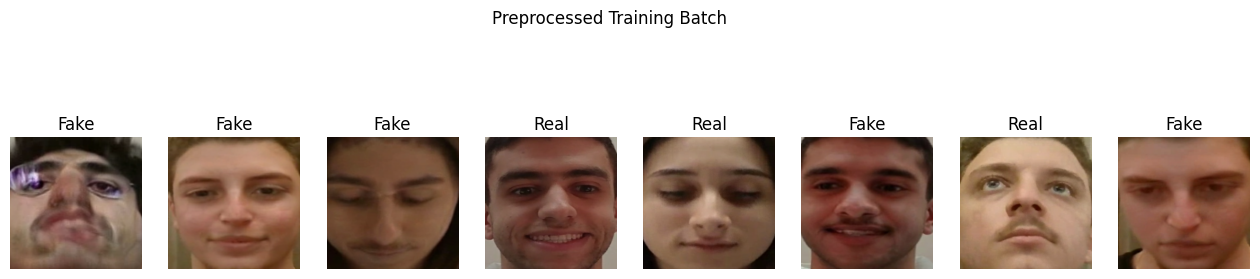

In [16]:
show_preprocessed_batch(train_gen, title="Preprocessed Training Batch")

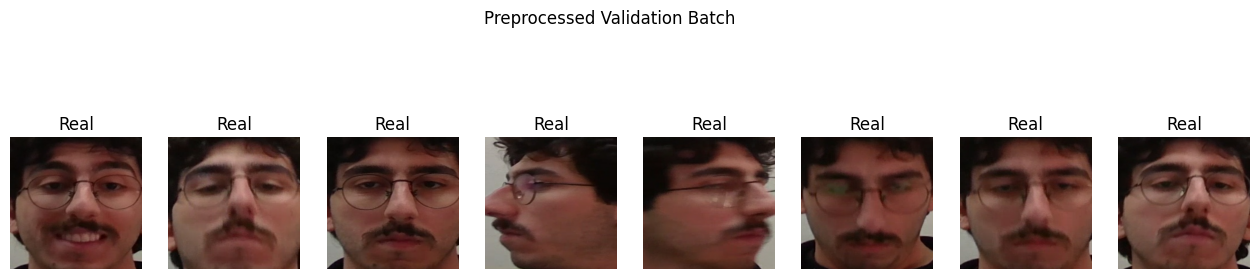

In [17]:
show_preprocessed_batch(val_gen, title="Preprocessed Validation Batch")

In [18]:
# Load base model without top layer
base_model = Xception(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

# Freeze base layers for transfer learning
base_model.trainable = False

# Add custom head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)


In [21]:
# Calculate class weights to handle imbalance
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels),
    y=train_labels
)
class_weights = dict(enumerate(class_weights))
print("Class Weights:", class_weights)

# Compile model
model.compile(
    optimizer=Adam(1e-4),
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.AUC(name='auc'),
    ]
)

Class Weights: {0: 1.6522842639593909, 1: 0.7169603524229075}


In [22]:
# Define early stopping
early_stop = EarlyStopping(
    monitor='val_loss',     # You can also use 'val_accuracy'
    patience=3,             # Stop after 3 epochs with no improvement
    restore_best_weights=True
)

# Train the model
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=20,  # or however many you want
    class_weight=class_weights,
    callbacks=[early_stop]
)


Epoch 1/20
41/41 [==============================] - 14s 266ms/step - loss: 0.6833 - accuracy: 0.5092 - precision: 0.7533 - recall: 0.4405 - auc: 0.5896 - val_loss: 0.6969 - val_accuracy: 0.4686 - val_precision: 0.8841 - val_recall: 0.4022 - val_auc: 0.6684
Epoch 2/20
41/41 [==============================] - 12s 273ms/step - loss: 0.6664 - accuracy: 0.5530 - precision: 0.7942 - recall: 0.4846 - auc: 0.6486 - val_loss: 0.6863 - val_accuracy: 0.5206 - val_precision: 0.9234 - val_recall: 0.4505 - val_auc: 0.7684
Epoch 3/20
41/41 [==============================] - 9s 197ms/step - loss: 0.6584 - accuracy: 0.5730 - precision: 0.7848 - recall: 0.5341 - auc: 0.6573 - val_loss: 0.6639 - val_accuracy: 0.6212 - val_precision: 0.9388 - val_recall: 0.5736 - val_auc: 0.8341
Epoch 4/20
41/41 [==============================] - 9s 199ms/step - loss: 0.6293 - accuracy: 0.6575 - precision: 0.8358 - recall: 0.6333 - auc: 0.7474 - val_loss: 0.6562 - val_accuracy: 0.6463 - val_precision: 0.9574 - val_recall:

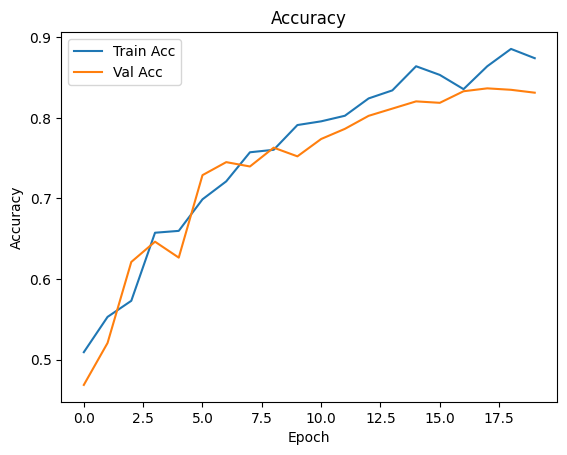

In [30]:
# Plot Accuracy
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

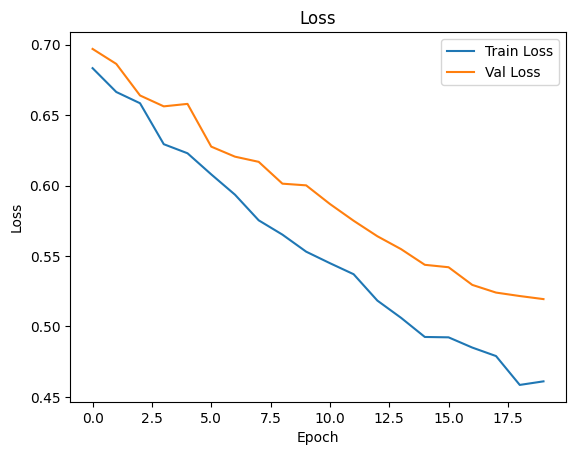

In [31]:
# Plot Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()


In [27]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

# 1. Unfreeze only the last 20 layers
for layer in base_model.layers[:-20]:
    layer.trainable = False
for layer in base_model.layers[-20:]:
    layer.trainable = True

# 2. Recompile with a smaller learning rate
model.compile(
    optimizer=Adam(1e-5),
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.AUC(name='auc'),
    ]
)

# 3. Early stopping to prevent overfitting
fine_tune_stop = EarlyStopping(
    monitor='val_loss',
    patience=2,
    restore_best_weights=True
)

# 4. Checkpoint to save the best model
checkpoint_cb = ModelCheckpoint(
    filepath='Xception_finetuned.h5',
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False,
    verbose=1
)

# 5. Use smaller batch size for fine-tuning
fine_tune_train_gen = train_gen.unbatch().batch(8).prefetch(tf.data.AUTOTUNE)
fine_tune_val_gen = val_gen.unbatch().batch(8).prefetch(tf.data.AUTOTUNE)

# 6. Train
fine_tune_history = model.fit(
    fine_tune_train_gen,
    validation_data=fine_tune_val_gen,
    epochs=10,
    class_weight=class_weights,
    callbacks=[fine_tune_stop, checkpoint_cb]
)


Epoch 1/10
    163/Unknown - 24s 84ms/step - loss: 0.5693 - accuracy: 0.5261 - precision: 0.9966 - recall: 0.3216 - auc: 0.9046
Epoch 1: val_loss improved from inf to 0.60677, saving model to best_model_finetuned.h5


/home/marounassaf_/tf_gpu/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


163/163 [==============================] - 31s 130ms/step - loss: 0.5693 - accuracy: 0.5261 - precision: 0.9966 - recall: 0.3216 - auc: 0.9046 - val_loss: 0.6068 - val_accuracy: 0.6266 - val_precision: 1.0000 - val_recall: 0.5429 - val_auc: 0.9948
Epoch 2/10
162/163 [============================>.] - ETA: 0s - loss: 0.3784 - accuracy: 0.8063 - precision: 0.9954 - recall: 0.7251 - auc: 0.9857
Epoch 2: val_loss improved from 0.60677 to 0.34474, saving model to best_model_finetuned.h5
163/163 [==============================] - 14s 81ms/step - loss: 0.3798 - accuracy: 0.8057 - precision: 0.9955 - recall: 0.7247 - auc: 0.9848 - val_loss: 0.3447 - val_accuracy: 0.8977 - val_precision: 1.0000 - val_recall: 0.8747 - val_auc: 0.9995
Epoch 3/10
163/163 [==============================] - ETA: 0s - loss: 0.2539 - accuracy: 0.9178 - precision: 0.9938 - recall: 0.8877 - auc: 0.9910
Epoch 3: val_loss improved from 0.34474 to 0.24589, saving model to best_model_finetuned.h5
163/163 [==================

18/18 [==============================] - 2s 137ms/step
              precision    recall  f1-score   support

        Real       0.75      0.92      0.82       102
        Fake       0.98      0.93      0.95       455

    accuracy                           0.93       557
   macro avg       0.86      0.93      0.89       557
weighted avg       0.94      0.93      0.93       557



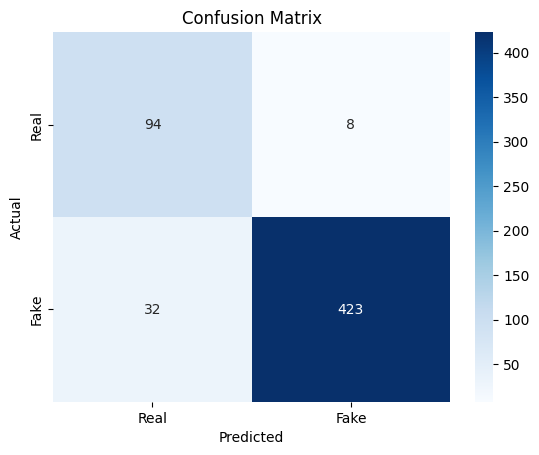

In [55]:
# Extract true labels
y_true = []
for _, labels in val_gen:
    y_true.extend(labels.numpy())  # Convert tensors to NumPy arrays

y_true = np.array(y_true)

# Get predictions
y_pred_probs = model.predict(val_gen)
y_pred = (y_pred_probs > 0.5).astype(int).flatten()

# Classification Report
print(classification_report(y_true, y_pred, target_names=["Real", "Fake"]))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Real", "Fake"], yticklabels=["Real", "Fake"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [45]:
def preprocess_fn(img):
    img = tf.image.resize(img, (299, 299))
    img = tf.keras.applications.xception.preprocess_input(img)
    return img

def load_and_preprocess_img(path):
    img_raw = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img_raw, channels=3)
    img = preprocess_fn(img)
    return tf.expand_dims(img, axis=0)  # Add batch dimension

def infer_on_folder(model, folder_path):
    results = []
    for fname in os.listdir(folder_path):
        if fname.lower().endswith((".jpg", ".jpeg", ".png")):
            img_path = os.path.join(folder_path, fname)
            img_tensor = load_and_preprocess_img(img_path)
            pred = model.predict(img_tensor, verbose=0)[0][0]
            label = "Fake" if pred > 0.5 else "Real"
            confidence = round(float(pred), 4) if label == "Fake" else round(1 - float(pred), 4)
            results.append((fname, label, confidence))

    # Display results
    for fname, label, confidence in results:
        print(f"{fname}: {label} ({confidence * 100:.2f}%)")

# Load face detector
detector = MTCNN()

# Run inference on a single video file
def infer_on_video_and_save(model, video_path, output_path, frame_skip=5):
    cap = cv2.VideoCapture(video_path)
    width  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps    = int(cap.get(cv2.CAP_PROP_FPS))

    # Define codec and output writer
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

    frame_count = 0
    predictions = []
    last_faces = []

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        frame_count += 1
        rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        # Run detection every 'frame_skip' frames
        if frame_count % frame_skip == 0:
            detections = detector.detect_faces(rgb_frame)
            if detections:
                last_faces = detections  # Update if new faces are detected

        for det in last_faces:
            x, y, w, h = det['box']
            x, y = max(0, x), max(0, y)
            face = rgb_frame[y:y+h, x:x+w]
            if face.size == 0:
                continue

            face_tensor = tf.convert_to_tensor(face, dtype=tf.uint8)
            face_tensor = preprocess_fn(face_tensor)
            face_tensor = tf.expand_dims(face_tensor, axis=0)
            pred = model.predict(face_tensor, verbose=0)[0][0]

            label = "Fake" if pred > 0.5 else "Real"
            confidence = round(float(pred), 4) if label == "Fake" else round(1 - float(pred), 4)
            predictions.append((frame_count, label, confidence))

            # Draw tag
            color = (0, 0, 255) if label == "Fake" else (0, 255, 0)
            cv2.rectangle(frame, (x, y), (x+w, y+h), color, 2)
            text = f"{label} ({confidence*100:.1f}%)"
            cv2.putText(frame, text, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)

        out.write(frame)

    cap.release()
    out.release()
    print(f"✅ Saved tagged video to: {output_path}")
    return predictions


In [36]:
infer_on_folder(model, "inference_Data/maroun")

face_0000.jpg: Fake (75.09%)
face_0001.jpg: Fake (92.48%)
face_0002.jpg: Fake (89.22%)
face_0003.jpg: Fake (96.48%)
face_0004.jpg: Fake (88.23%)
face_0005.jpg: Fake (93.01%)
face_0006.jpg: Fake (95.79%)
face_0007.jpg: Fake (94.97%)
face_0008.jpg: Fake (93.69%)
face_0009.jpg: Fake (82.64%)
face_0010.jpg: Fake (95.31%)
face_0011.jpg: Fake (96.01%)
face_0012.jpg: Fake (94.61%)
face_0013.jpg: Fake (89.11%)
face_0014.jpg: Fake (93.02%)
face_0015.jpg: Fake (95.04%)
face_0016.jpg: Fake (96.76%)
face_0017.jpg: Fake (94.47%)
face_0018.jpg: Fake (95.94%)
face_0019.jpg: Fake (84.96%)
face_0020.jpg: Fake (92.88%)
face_0021.jpg: Fake (85.16%)
face_0022.jpg: Fake (96.88%)
face_0023.jpg: Fake (87.19%)
face_0024.jpg: Fake (93.14%)
face_0025.jpg: Fake (95.82%)
face_0026.jpg: Fake (96.95%)
face_0027.jpg: Fake (88.76%)
face_0028.jpg: Fake (95.14%)
face_0029.jpg: Fake (95.76%)
face_0030.jpg: Fake (92.15%)
face_0031.jpg: Fake (98.15%)
face_0032.jpg: Fake (96.37%)
face_0033.jpg: Fake (97.87%)
face_0034.jpg:

In [47]:
#model = load_model("xception_deepfake_model.h5")
video_path = "inference_Data/maroun_real.mp4"
output_path = f"{video_path}_output.mp4"
predictions = infer_on_video_and_save(model, video_path, output_path)

✅ Saved tagged video to: inference_Data/maroun_real.mp4_output.mp4
